# ML Notebook 04 : Failure Analysis of Bag of Visual Features Clustering

In [3]:
import pandas as pd
import copyreg
import pickle

import numpy as np
import cv2
import os
from scipy import ndimage
from scipy.spatial import distance
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from collections import Counter


In [20]:
plt.style.use('ggplot') # fast
plt.style.use('fast')
plt.rcParams['axes.grid'] = False

In [4]:
# before we go any further let's save some files
with open('data/SCUT-FBP5500_v2/train_bovw_list', 'rb') as d:
    train_orb = pickle.load(d)
    
with open('data/SCUT-FBP5500_v2/train_orb_dict', 'rb') as d:
    train_orb_dict = pickle.load(d)

In [5]:
with open('data/SCUT-FBP5500_v2/visual_words_500_centers', 'rb') as d:
    visual_words_500 = pickle.load(d)

In [6]:
def keypoint_class(bovw_dict, centers, kp_pos):
    """
    This is a helper function that analyzes the euclidean distance between the kp_pos(postion number) keypoint in an image 
    and the topic cluster centers. It then maps that keypoint to its "topic" ie the closest cluster center.
    
    Params:
    all_bovw: A dictionary that holds the keypoints as values and is separated by image filename key 
    centers: An array that holds the central points (visual topics) of the k means clustering
    
    Return:
    feat_dict : dictionary that holds the cluster center number for the first keypoint in each image. 
    
    """
    
    # here I am going to take the first keypoint in every image
    all_bovw = {k:[v[kp_pos]] for k,v in bovw_dict.items()}
    
    def find(element, matrix):
        for i, matrix_i in enumerate(matrix):
            for j, value in enumerate(matrix_i):
                if value == element:
                    return (i, j)
            
    dict_keys = []
    feats = []
    for key,value in all_bovw.items():
        dict_keys.append(key)
        # obtains distance/closeness to centers for keypoints
        dist = distance.cdist(value, centers, metric='euclidean')
        
        # argmin for each of key points, get the closest feature vocab (center)
        bin_assignment = np.argmin(dist, axis=1)
        
        # classify each kp into symbols
        # create histogram with size N describing number of symbols
        histogram = np.zeros(len(centers))
        for id_assign in bin_assignment:
            histogram[id_assign] += 1
        
        # assign the location to global features
        # using index we can find the position of the only keypoint mapped    
        feats.append(list(histogram).index(1))
        
    # feats now holds all the image features
    feat_dict = {k:v for k,v in zip(dict_keys, feats)}

    return feat_dict

In [7]:
keypoints_mapped = keypoint_class(train_orb_dict, visual_words_500, 10)

In [8]:
counts = Counter(keypoints_mapped.values())

In [9]:
counts

Counter({208: 4,
         30: 3,
         358: 11,
         49: 26,
         447: 7,
         471: 8,
         142: 18,
         85: 24,
         313: 10,
         472: 8,
         305: 5,
         67: 12,
         193: 8,
         378: 7,
         126: 9,
         149: 4,
         78: 5,
         111: 3,
         47: 8,
         99: 13,
         198: 7,
         122: 11,
         397: 6,
         499: 8,
         52: 3,
         497: 7,
         260: 11,
         203: 7,
         359: 19,
         92: 21,
         350: 5,
         189: 15,
         22: 8,
         44: 9,
         303: 16,
         118: 13,
         302: 10,
         146: 7,
         372: 17,
         106: 6,
         23: 3,
         414: 4,
         493: 13,
         61: 5,
         152: 10,
         288: 6,
         215: 8,
         333: 15,
         214: 1,
         233: 7,
         247: 14,
         105: 16,
         481: 8,
         159: 5,
         273: 5,
         157: 7,
         459: 7,
         487: 5,
      

In [10]:
# read in the dataframe with keypoints
path = 'data/SCUT-FBP5500_v2/reduced/'
fl = sorted(os.listdir(path))
fl.remove('.DS_Store') 

comp_df = pd.DataFrame()
for _, p in enumerate(fl):
    comp_df = pd.concat([comp_df,pd.read_pickle(path + p)])
print(f'done')

done


In [11]:
def draw_kp(image, df, num):
    """this takes an image and plots the keypoint on the image"""
    df_flt = df[df.Filename == image]
    img = cv2.imread('data/SCUT-FBP5500_v2/Images/'+image)
    resultimage = cv2.drawKeypoints(img, [df_flt.orb_kp.iloc[0][0]], 0, (0, 255, 0), flags=0)
    plt.imshow(cv2.cvtColor(resultimage, cv2.COLOR_BGR2RGB))
    plt.title(f'ORB KEYPOINT {num}', fontdict={'color':'black'})
    plt.show()
    return

def select_plot_kp(num, kp_dict, df):
    """this takes a keypoint number and plots all images with it"""
    il = [k for k,v in kp_dict.items() if v == num]
    kp = df[['Filename','orb_kp','orb_dec']][df.Filename.isin(il)]
    for pic in il:
        draw_kp(pic, kp, num)
    return

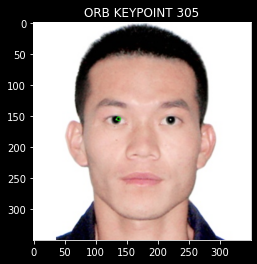

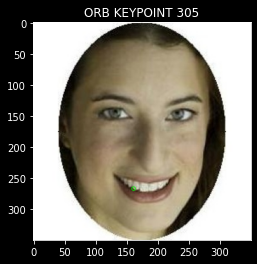

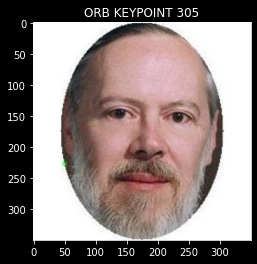

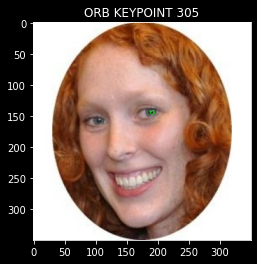

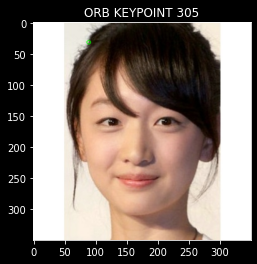

In [108]:
select_plot_kp(305, keypoints_mapped, comp_df)

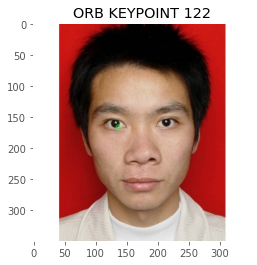

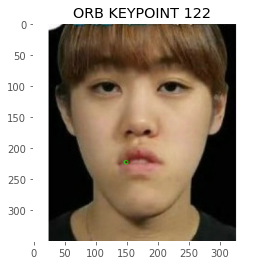

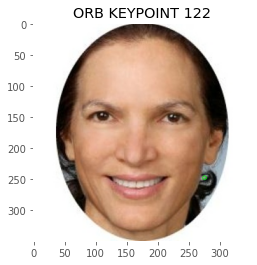

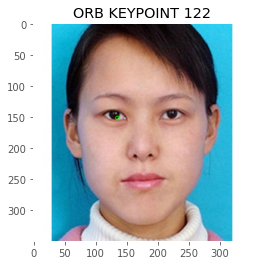

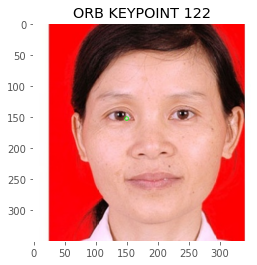

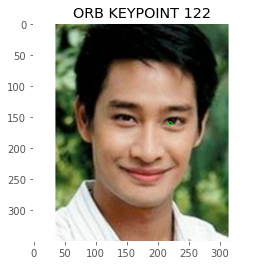

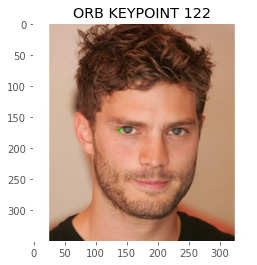

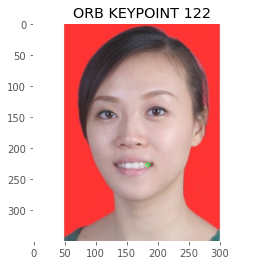

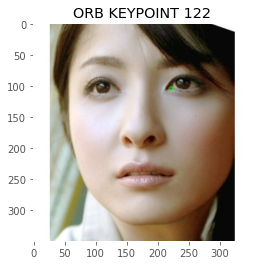

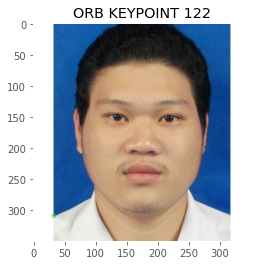

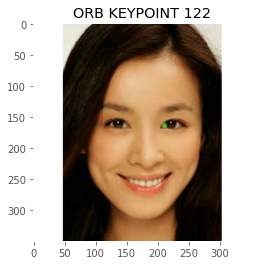

In [19]:
select_plot_kp(122, keypoints_mapped, comp_df)

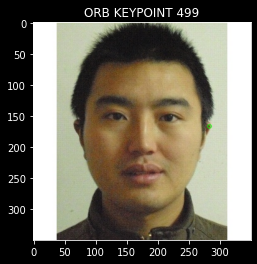

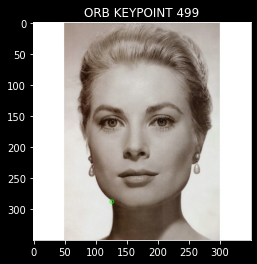

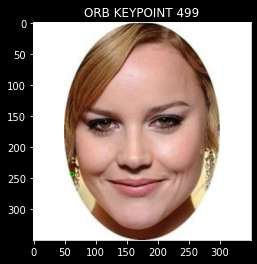

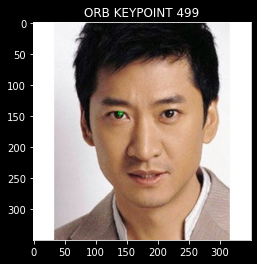

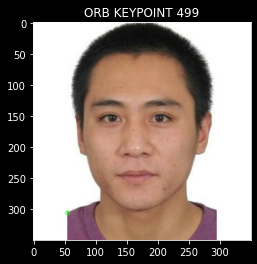

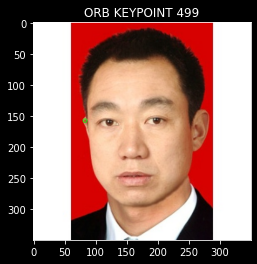

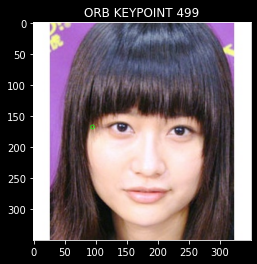

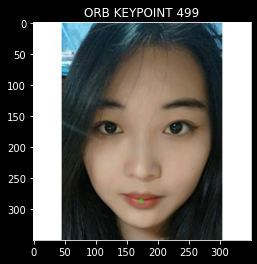

In [110]:
select_plot_kp(499, keypoints_mapped, comp_df)

In [22]:
# failure analysis PAC

# read in scores for charting
test_scores_df = pd.read_csv('data/SCUT-FBP5500_v2/scores/test_scores_PAC_complete.csv')
test_scores_df.columns

Index(['Unnamed: 0', 'filename', 'rating', 'pred_rating', 'Unnamed: 0.1'], dtype='object')

In [56]:
test_scores_df['difference'] = abs(test_scores_df.rating - test_scores_df.pred_rating)

In [25]:
test_scores_df.drop(columns=['Unnamed: 0','Unnamed: 0.1'], inplace=True)

In [28]:
test_scores_df.groupby(['rating','diff']).count()

filename  pred_rating
rating diff                       
1      1           11           11
       2            1            1
2      0          531          531
       1            6            6
       2            3            3
3      0           45           45
       1         1033         1033
4      0           89           89
       1           17           17
       2          453          453
5      1            4            4
       3            7            7

In [29]:
import seaborn as sns

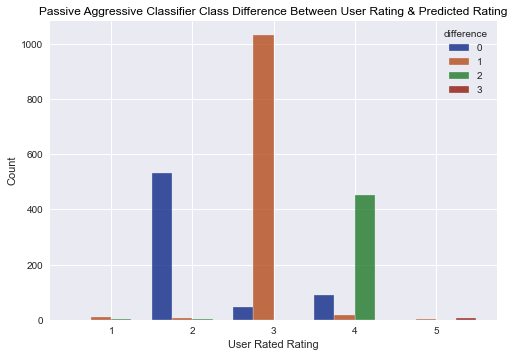

In [59]:
plt.style.use('seaborn')
sns.histplot(data=test_scores_df,x="rating", hue="difference",multiple="dodge",palette="dark", discrete=True,stat='count')
plt.xlabel('User Rated Rating')
plt.title('Passive Aggressive Classifier Class Difference Between User Rating & Predicted Rating', fontdict={'color':'black'})
plt.show()